In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../preprocessing/')
sys.path.insert(0, '../')

import ESM_utils as esm
import os
import glob 
import shutil 
import re
#import plotly.graph_objects as go

import nibabel as nib

import create_pet_probability_matrix

import pandas as pd
import numpy as np
import nilearn.plotting as plotting
import itertools
import matplotlib.colors as colors
import seaborn as sns

import matplotlib.pyplot as plt
import math
from statannot import add_stat_annotation

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from nilearn import input_data, image

In [2]:
def intersection(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

In [3]:
clinical_df = pd.read_csv("../../data/DIAN/participant_metadata/CLINICAL_D1801.csv")
genetic_df = pd.read_csv("../../data/DIAN/participant_metadata/GENETIC_D1801.csv")
pib_df = pd.read_csv("../../data/DIAN/participant_metadata/pib_D1801.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (139,152,512,991,997,999,1001,1003,1005,1013,1015,1019,1021,1039,1041,1043,1113,1117) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dian_pup_voxelwise_ecdf_v00 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v00.csv", index_col=0)
dian_pup_voxelwise_ecdf_v00.loc[:, 'visit'] = "v00"
dian_pup_voxelwise_ecdf_v01 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v01.csv", index_col=0)
dian_pup_voxelwise_ecdf_v01.loc[:, 'visit'] = "v01"
dian_pup_voxelwise_ecdf_v02 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v02.csv", index_col=0)
dian_pup_voxelwise_ecdf_v02.loc[:, 'visit'] = "v02"
dian_pup_voxelwise_ecdf_v03 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v03.csv", index_col=0)
dian_pup_voxelwise_ecdf_v03.loc[:, 'visit'] = "v03"
dian_pup_voxelwise_ecdf_v04 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v04.csv", index_col=0)
dian_pup_voxelwise_ecdf_v04.loc[:, 'visit'] = "v04"
dian_pup_voxelwise_ecdf_v05 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v05.csv", index_col=0)
dian_pup_voxelwise_ecdf_v05.loc[:, 'visit'] = "v05"

In [5]:
### drop BS2VBS at v03 & "U482R7" at v00 as they were not fully processed with PUP
dian_pup_voxelwise_ecdf_v00 = dian_pup_voxelwise_ecdf_v00[dian_pup_voxelwise_ecdf_v00.index != "U482R7"]
dian_pup_voxelwise_ecdf_v03 = dian_pup_voxelwise_ecdf_v03[dian_pup_voxelwise_ecdf_v03.index != "BS2VBS"]

In [6]:
dian_pup_voxelwise_ecdf_all_visits = pd.concat([dian_pup_voxelwise_ecdf_v00,
                                                dian_pup_voxelwise_ecdf_v01, 
                                                dian_pup_voxelwise_ecdf_v02, 
                                                dian_pup_voxelwise_ecdf_v03,
                                                dian_pup_voxelwise_ecdf_v04,
                                                dian_pup_voxelwise_ecdf_v05])

In [7]:
roi_cols = dian_pup_voxelwise_ecdf_all_visits.columns[0:78]
subcortical_cols = ["globus pallidus", "thalamus", "hypothalamus", "putamen"]
roi_cols_to_exclude = [] 
for col in roi_cols: 
    for bad_col in subcortical_cols: 
        if bad_col in col.lower(): 
            roi_cols_to_exclude.append(col)
roi_cols_to_keep = [x for x in roi_cols if x not in roi_cols_to_exclude]
dian_pup_voxelwise_ecdf_all_visits[roi_cols_to_exclude] = 0

In [173]:
pup_cortical_analysis_col_idx = []
pup_cortical_analysis_col_names = []

for i, roi in enumerate(roi_cols_to_keep): 
    if "precuneus" in roi.lower() or "superior frontal" in roi.lower() \
        or "rostral middle frontal" in roi.lower() or "lateral orbitofrontal" in roi.lower() \
        or "medial orbitofrontal" in roi.lower() or "superior temporal" in roi.lower() \
        or "middle temporal" in roi.lower() or "posterior cingulate" in roi.lower(): 
        print(i, roi)
        pup_cortical_analysis_col_idx.append(i)
        pup_cortical_analysis_col_names.append(roi)

11 Left Medial orbitofrontal
12 Left Middle temporal
20 Left Posterior cingulate
22 Left Precuneus
24 Left Rostral middle frontal
25 Left Superior frontal
27 Left Superior Temporal
46 Right Medial orbitofrontal
47 Right Middle temporal
55 Right Posterior cingulate
57 Right Precuneus
59 Right Rostral middle frontal
60 Right Superior frontal
62 Right Superior Temporal


In [8]:
for sub in dian_pup_voxelwise_ecdf_all_visits.index: 
    sub_df = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.index == sub]
    visits = list(sub_df.visit)
    mutation = genetic_df[(genetic_df.IMAGID == sub)].Mutation.values[0]
    for i in range(0, len(visits)):
        visit = visits[i]
        dian_eyo = clinical_df[(clinical_df.IMAGID == sub) & (clinical_df.visit == visit)].DIAN_EYO.values
        age = clinical_df[(clinical_df.IMAGID == sub) & (clinical_df.visit == visit)].VISITAGEc.values
        if len(dian_eyo) == 0:
            print(sub + " " + visit)
        if len(dian_eyo) > 0:
            dian_pup_voxelwise_ecdf_all_visits.loc[(dian_pup_voxelwise_ecdf_all_visits.index == sub) & (dian_pup_voxelwise_ecdf_all_visits.visit == visit), "DIAN_EYO"] = dian_eyo[0]
            dian_pup_voxelwise_ecdf_all_visits.loc[(dian_pup_voxelwise_ecdf_all_visits.index == sub) & (dian_pup_voxelwise_ecdf_all_visits.visit == visit), "VISITAGEc"] = age[0]
            dian_pup_voxelwise_ecdf_all_visits.loc[(dian_pup_voxelwise_ecdf_all_visits.index == sub) & (dian_pup_voxelwise_ecdf_all_visits.visit == visit), "visitNumber"] = i + 1
            dian_pup_voxelwise_ecdf_all_visits.loc[(dian_pup_voxelwise_ecdf_all_visits.index == sub) & (dian_pup_voxelwise_ecdf_all_visits.visit == visit), "Mutation"] = mutation

In [9]:
dian_pup_voxelwise_ecdf_all_visits.loc[:, roi_cols].head()

,Left Caudal anterior cingulate,Left Caudal middle frontal,Left Cuneus,Left entorinal,Left fusiform,Left Inferior parietal,Left Inferior temporal,Left Isthmus cingulate,Left Lateral Occipital,Left Lateral orbitofronal,...,Right Transverse temporal,Right Insula,Right Basal forebrain,Right Amygdala,Right Hypothalamus,Right Caudate,Right Hippocampus,Right Globus Pallidus,Right Putamen,Right Thalamus
09NXRZ,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000873,0.000000,0.000000,0.001178,0.001435,...,0.000000,0.000315,0.438316,0.001847,0,0.800702,2.282584e-04,0,0,0
0F9ACS,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0,0,0
0LA7SQ,0.952713,0.400071,6.360225e-01,0.002138,0.24708,0.402461,0.322673,0.750151,0.355474,0.500048,...,0.065097,0.270181,0.830855,0.000000,0,0.634945,5.246594e-15,0,0,0
0O5OD0,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000364,0.000000,0.000000,0,0.000285,0.000000e+00,0,0,0
0RN4X6,0.000000,0.000000,6.328179e-122,0.000000,0.00000,0.002050,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0,0,0


In [10]:
# create separate dataframes for the different timepoints

dian_pup_voxelwise_ecdf_first_timepoint = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1]
dian_pup_voxelwise_ecdf_second_timepoint = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 2]
dian_pup_voxelwise_ecdf_third_timepoint = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 3]
dian_pup_voxelwise_ecdf_fourth_timepoint = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 4]
dian_pup_voxelwise_ecdf_fifth_timepoint = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 5]



In [81]:
dian_pup_voxelwise_ecdf_mc_avg_all_visits_df = pd.DataFrame(index=["t1", "t2", "t3", "t4", "t5"], 
                                                            columns=roi_cols, 
                                                            dtype="float")
indices = ["t1", "t2", "t3", "t4", "t5"]
for i in range(0, 5): 
    j = i+1
    idx = indices[i]
    for roi in roi_cols: 
        dian_pup_voxelwise_ecdf_mc_avg_all_visits_df.loc[idx, roi] = np.mean(dian_pup_voxelwise_ecdf_all_visits[(dian_pup_voxelwise_ecdf_all_visits.Mutation == 1) & (dian_pup_voxelwise_ecdf_all_visits.visitNumber == j)][roi])

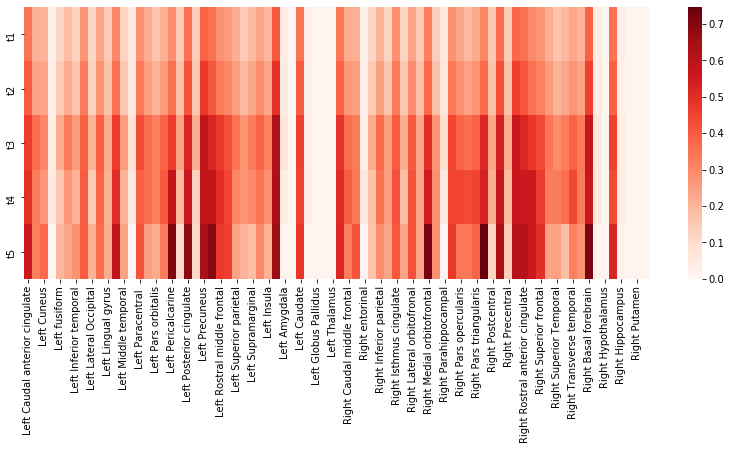

In [88]:
fig = plt.figure(figsize=(14,5))
g = sns.heatmap(dian_pup_voxelwise_ecdf_mc_avg_all_visits_df,cmap="Reds")


In [93]:
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from datetime import date
import plotly.express as px

In [95]:
dian_pup_voxelwise_ecdf_all_visits.shape

(712, 83)

In [ ]:
# create the gantt plot for all individuals who have 3 timepoints at first  

In [137]:
len(set(dian_pup_voxelwise_ecdf_all_visits.index))

423

In [174]:
ab_prob_gantt_df = pd.DataFrame(columns=["Task", "Start", "Finish", "Complete"])
idx = 0
for sub in dian_pup_voxelwise_ecdf_all_visits.index:
    print(sub)
    sub_df = dian_pup_voxelwise_ecdf_all_visits.loc[sub, :]
    if sub_df.shape[0] == 3: 
        avg_prob_t1 = np.mean(dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1].loc[sub, pup_cortical_analysis_col_names])
        avg_prob_t2 = np.mean(dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 2].loc[sub, pup_cortical_analysis_col_names])
        avg_prob_t3 = np.mean(dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 3].loc[sub, pup_cortical_analysis_col_names])
        dian_eyo_t1 = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1].loc[sub, 'DIAN_EYO']
        dian_eyo_t2 = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 2].loc[sub, 'DIAN_EYO']
        dian_eyo_t3 = dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 3].loc[sub, 'DIAN_EYO']
        
        ab_prob_gantt_df.loc[idx, 'Task'] = sub 
        ab_prob_gantt_df.loc[idx, 'Mutation'] = dian_pup_voxelwise_ecdf_all_visits.loc[sub, 'Mutation'].values[0]
        ab_prob_gantt_df.loc[idx, 'Start'] = dian_eyo_t1
        ab_prob_gantt_df.loc[idx, 'Finish'] = dian_eyo_t2
        ab_prob_gantt_df.loc[idx, 'Complete'] = avg_prob_t2 - avg_prob_t1
        ab_prob_gantt_df.loc[idx, 'Duration'] = ab_prob_gantt_df.loc[idx, 'Finish'] - ab_prob_gantt_df.loc[idx, 'Start']
        
        
        idx += 1 
        ab_prob_gantt_df.loc[idx, 'Task'] = sub 
        ab_prob_gantt_df.loc[idx, 'Mutation'] = dian_pup_voxelwise_ecdf_all_visits.loc[sub, 'Mutation'].values[0]
        ab_prob_gantt_df.loc[idx, 'Start'] = dian_eyo_t2
        ab_prob_gantt_df.loc[idx, 'Finish'] = dian_eyo_t3
        ab_prob_gantt_df.loc[idx, 'Complete'] = avg_prob_t3 - avg_prob_t2
        ab_prob_gantt_df.loc[idx, 'Duration'] = ab_prob_gantt_df.loc[idx, 'Finish'] - ab_prob_gantt_df.loc[idx, 'Start']
        
        idx += 1

09NXRZ
0F9ACS
0LA7SQ
0O5OD0
0RN4X6
0WWEAW
0ZI871
10H57G
14OWZV
19XN9M
1CWD6M
1EBBWV
1FXQEE
1GXVHT
1KP11R
1UANEQ
1WQJWP
1X8U58
293IV5
2AX5FU
2D1APM
2ES6B9
2FAMDB
2N6SUC
2P1WOY
2VVTM5
2WBJW3
2WKQWT
2Y4O0X
30LR7L
34E2IA
3ER4GO
3GTJ22
3QM9OP
3RC7PE
3RQ6TO
3WKEFU
3WWCQ9
3XPANM
3YMWAT
41L6T6
41VBKZ
43H9Y6
44CAVQ
48XWC1
4J49QW
4KEGQV
4LLB2T
4VKJET
4X8C24
4YW4W5
54GI9H
54UDP0
56ET2I
5A2RSX
5FZWKH
5HQBDJ
5ILQGC
5KD9CG
5LGJ8I
5LXI2Z
5OGELK
5S73B5
5Y8CIX
62GER7
62UV1H
65ACYY
67YHUY
6AK49W
6CMY4P
6KVLEL
6TATLD
6X8RJM
6XGHMZ
6XVFTZ
71EU2X
729WMJ
76HB24
79LG99
7CMJYQ
7HL4NW
7MUSGY
7OQNFQ
7U5XQ7
7WX8KG
7X34D1
7XRXWC
837HA5
83EINK
89MLR7
8AKUN6
8AQM2F
8B59ST
8CCNE3
8ERSFM
8FDLTX
8H52AT
8IFJ11
8MQWHN
8UFV8Z
8XXUDD
8Z9RLA
9KOPAV
9QO2AT
9QUQQI
9V76YB
9VQ5Z6
A401RO
A6B7EX
ABOX7W
AEXGEP
ALSGL2
ANUED7
AODS2H
AP992Q
ATI0ZK
AWV50K
AZ5MWZ
AZVW0Q
B93NRI
BAV0RI
BK265G
BMV2ZL
BNAJMF
BNX2XO
BOKD4Y
BPN5U8
BS2VBS
C3YSZL
CD8IP3
CDBBBU
CEYMNN
CTPZ0W
CXRL3E
D0IS2S
D1YOXP
D6NMT1
D6TIH6
D6XWA2
DA0DVX
DDZ9FW
DEHYCW
DF2ECY

In [184]:
dian_pup_voxelwise_ecdf_all_visits.loc['293IV5', 'Left Posterior cingulate']

293IV5    0.004674
293IV5    0.000353
293IV5    0.000000
Name: Left Posterior cingulate, dtype: float64

In [183]:
ab_prob_gantt_df

,Task,Start,Finish,Complete,Mutation,Duration
0,293IV5,-20.5849,-17.4041,-0.00131574,0.0,3.180822
1,293IV5,-17.4041,-15.509,-0.000539972,0.0,1.895134
2,4LLB2T,1.48361,3.6275,-0.00467785,1.0,2.143896
3,4LLB2T,3.6275,5.52459,0.116123,1.0,1.897088
4,5FZWKH,-21.1134,-18.0887,1.73286e-05,1.0,3.024658
...,...,...,...,...,...,...
277,V24NB2,-17.7801,-15.6142,0,0.0,2.165985
278,VMGRO8,-9.29472,-6.29198,-0.000344269,1.0,3.002740
279,VMGRO8,-6.29198,-4.28193,-8.29247e-05,1.0,2.010046
280,XJCYRZ,-16.2664,-13.1431,5.02696e-05,0.0,3.123288


In [175]:
def ab_eyo_gantt_plot(df, mut_status, minn=-0.15): 
    df_sorted = df[ab_prob_gantt_df.Mutation == mut_status].sort_values("Start", ascending=False)
    # set colour map
    cmap = px.colors.diverging.balance

    ind0 = df_sorted.index[0]

    fig = go.Figure()
    minn = minn
    maxx = -minn

    for idx, row in df_sorted.iterrows():

        # Potential Update: change opacity based on AB proba at start of bar
        # then, potentially, colour bars by normalized change (i.e. change / start proba)
        alpha = 1 # opacity
        
        # Set colour bin from value -> map
        c = int(np.floor(len(cmap)*(row.Complete - minn) / (maxx - minn)))

        # Make sure c is a valid index ... i.e. [ 0, len(cmap) ) 
        c = len(cmap) - 1 if c >= len(cmap) else c
        c = 0 if c < 0 else c

        # Only add colourbar one a single bar (its the same)
        if idx == ind0:
            marker = {"cmin": minn,
                      "cmax": maxx,
                      "showscale": True,
                      "color": cmap[c],
                      "opacity": alpha,
                      "colorscale": cmap}
        else:
            marker={"color": cmap[c],
                    "opacity": alpha,
                    "cmin": minn,
                    "cmax": maxx}

        # Add bar plot trace
        fig.add_trace(go.Bar(x0=row.Duration,
                             base=[row.Start],
                             y=[row.Task],
                             orientation='h',
                             marker=marker,
                             hovertext=row.Complete,
                             width=1))

    if mut_status == 1: 
        mut_status = "Mutation Carriers"
    else: 
        mut_status = "Noncarriers"
        
    fig.update_layout(showlegend=False, plot_bgcolor='rgb(255,255,255)',
                      title="AB Deposition Change Between Visits (" + mut_status + ")",
                      
                      yaxis={"title": "Subject", "tickvals": []},
                      xaxis={"title": "Estimated Years to Symptom Onset"})
    fig.show()

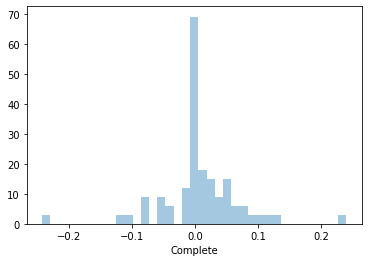

In [180]:
sns.distplot(ab_prob_gantt_df[ab_prob_gantt_df.Mutation == 1].Complete, kde=False)

In [181]:
ab_eyo_gantt_plot(ab_prob_gantt_df, mut_status=1, minn=-0.25)